The first example of pyamg tutorial: a rotated anisotropic diffusion problem from the pyamg.gallery.

First, a basic smoothed aggregation solver is constructed. Then, many of the options are modified to yield a more effective solver.

In [1]:
# ------------------------------------------------------------------
# Step 1: import scipy and pyamg packages
# ------------------------------------------------------------------
import numpy as np
import pyamg
import matplotlib.pyplot as plt

In [2]:
# ------------------------------------------------------------------
# Step 2: setup up the system using pyamg.gallery
# ------------------------------------------------------------------
n = 200
X, Y = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))
stencil = pyamg.gallery.diffusion_stencil_2d(type='FE', epsilon=0.001, theta=np.pi / 3)
A = pyamg.gallery.stencil_grid(stencil, (n, n), format='csr')
b = np.random.rand(A.shape[0])                     # pick a random right hand side

In [3]:
# ------------------------------------------------------------------
# Step 3: setup of the multigrid hierarchy
# ------------------------------------------------------------------
ml = pyamg.smoothed_aggregation_solver(A)   # construct the multigrid hierarchy

In [4]:
# ------------------------------------------------------------------
# Step 4: solve the system
# ------------------------------------------------------------------
res1 = []
x = ml.solve(b, tol=1e-12, residuals=res1)  # solve Ax=b to a tolerance of 1e-12


In [5]:
# ------------------------------------------------------------------
# Step 5: print details
# ------------------------------------------------------------------
print("\n")
print("Details: Default AMG")
print("--------------------")
print(ml)                                 # print hierarchy information

print("The residual norm is {}".format(np.linalg.norm(b - A * x)))  # compute norm of residual vector



Details: Default AMG
--------------------
multilevel_solver
Number of Levels:     5
Operator Complexity:  1.125
Grid Complexity:      1.127
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0        40000       357604 [88.91%]
    1         4489        39601 [ 9.85%]
    2          529         4489 [ 1.12%]
    3           64          484 [ 0.12%]
    4            9           49 [ 0.01%]

The residual norm is 0.1663995476828167


In [6]:
# notice that there are 5 (or maybe 6) levels in the hierarchy
#
# we can look at the data in each of the levels
# e.g. the multigrid components on the finest (0) level
#      A: operator on level 0
#      P: prolongation operator mapping from level 1 to level 0
#      R: restriction operator mapping from level 0 to level 1
#      B: near null-space modes for level 0
#      presmoother: presmoothing function taking arguments (A,x,b)
#      postsmoother: postsmoothing function taking arguments (A,x,b)
print("\n")
print("The Multigrid Hierarchy")
print("-----------------------")
for l in range(len(ml.levels)):
    An = ml.levels[l].A.shape[0]
    Am = ml.levels[l].A.shape[1]
    if l == (len(ml.levels)-1):
        print(f"A_{l}: {An:>10}x{Am:<10}")
    else:
        Pn = ml.levels[l].P.shape[0]
        Pm = ml.levels[l].P.shape[1]
        print(f"A_{l}: {An:>10}x{Am:<10}   P_{l}: {Pn:>10}x{Pm:<10}")



The Multigrid Hierarchy
-----------------------
A_0:      40000x40000        P_0:      40000x4489      
A_1:       4489x4489         P_1:       4489x529       
A_2:        529x529          P_2:        529x64        
A_3:         64x64           P_3:         64x9         
A_4:          9x9         


In [9]:
for l in range(len(ml.levels)):
    #Pn = ml.levels[l].P.shape[0]
    #Pm = ml.levels[l].P.shape[1]
    #print(f"P_{l}: {Pn:>10}x{Pm:<10}")
    Rn = ml.levels[l].R.shape[0]
    Rm = ml.levels[l].R.shape[1]
    print(f"R_{l}: {Rn:>10}x{Rm:<10}")

R_0:       4489x40000     
R_1:        529x4489      
R_2:         64x529       
R_3:          9x64        


AttributeError: 'level' object has no attribute 'R'

In [10]:
# ------------------------------------------------------------------
# Step 6: change the hierarchy
# ------------------------------------------------------------------
# we can also change the details of the hierarchy
ml = pyamg.smoothed_aggregation_solver(A,  # the matrix
                                       B=X.reshape(n * n, 1),             # the representation of the near null space (this is a poor choice)
                                       BH=None,                           # the representation of the left near null space
                                       symmetry='hermitian',              # indicate that the matrix is Hermitian
                                       strength='evolution',              # change the strength of connection
                                       aggregate='standard',              # use a standard aggregation method
                                       smooth=('jacobi', {'omega': 4.0 / 3.0, 'degree': 2}),   # prolongation smoothing
                                       presmoother=('block_gauss_seidel', {'sweep': 'symmetric'}),
                                       postsmoother=('block_gauss_seidel', {'sweep': 'symmetric'}),
                                       improve_candidates=[('block_gauss_seidel',
                                                           {'sweep': 'symmetric', 'iterations': 4}), None],
                                       max_levels=10,                     # maximum number of levels
                                       max_coarse=5,                      # maximum number on a coarse level
                                       keep=False)                        # keep extra operators around in the hierarchy (memory)

In [11]:
# ------------------------------------------------------------------
# Step 7: print details
# ------------------------------------------------------------------
res2 = []                                               # keep the residual history in the solve
x = ml.solve(b, tol=1e-12, residuals=res2)              # solve Ax=b to a tolerance of 1e-12
print("\n")
print("Details: Specialized AMG")
print("------------------------")
print(ml)                                               # print hierarchy information
print("The residual norm is {}".format(np.linalg.norm(b - A * x)))  # compute norm of residual vector
print("\n")



Details: Specialized AMG
------------------------
multilevel_solver
Number of Levels:     6
Operator Complexity:  2.159
Grid Complexity:      1.201
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0        40000       357604 [46.31%]
    1         6700       226352 [29.31%]
    2         1232       176222 [22.82%]
    3          109        11829 [ 1.53%]
    4           13          169 [ 0.02%]
    5            2            4 [ 0.00%]

The residual norm is 9.812288002410554e-11




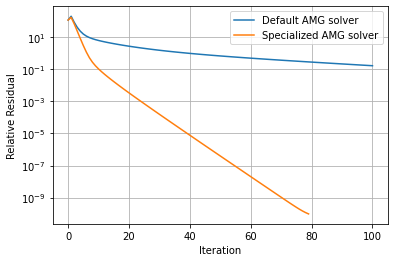

In [12]:

# ------------------------------------------------------------------
# Step 8: plot convergence history
# ------------------------------------------------------------------
fig, ax = plt.subplots()
ax.semilogy(res1, label='Default AMG solver')
ax.semilogy(res2, label='Specialized AMG solver')
ax.set_xlabel('Iteration')
ax.set_ylabel('Relative Residual')
ax.grid(True)
plt.legend()